In [1]:
# Essential plotting and scientific libraries
import matplotlib.pyplot as pl
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import numpy as np

from numpy import fft

from skimage.io import imread
from skimage.transform import resize

# IPython display imports
from ipywidgets import interact, FloatSlider, IntSlider, RadioButtons, Button, HBox, VBox, Checkbox
from IPython.display import Image, display, clear_output


from scipy.misc import face
face = face() # An example image we can use
from scipy.signal import convolve2d

import wave

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; height:95%; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

HTML('''<script>
    code_show=true; 
    function code_toggle() {
         if (code_show){
         $('div.input').hide();
         } else {
         $('div.input').show();
         }
         code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
    ''')

## Filtering and Image Enhancement
<br>
Enhancement methods are commonly commonly applied to image pixel intensities to improve image in some way.<br><br>
This could include (amongst many others):
 <ol>
     <li> Improving the <b>contrast</b> in the image to highlight a specific areas>
     <li> Adjusting the <b>brightness</b> of the image to help adjust for account for background lighting.
     <li> Reducing the amount of <b>noise</b> in the image.
     <li> Enhancing specific <b>features</b> in the image such as edges. 
</ol>
<br>

Filters generally fall into 3 classes:
<ol>
    <li> <b>Point operators</b> modify individual pixel levels in some way, for example to modify the contrast or brightness in the image.
    <li> <b>Spatial operators</b> modify the pixel values in some way, but also take into consideration the <b>neighborhood</b> of the pixel.
    <li> <b>Transform operators</b> modify the pixels after some transformation of the image. For example this could be modification of frequency space after Fourier transformation of the image.
</ol>

## Brightness

- Computer monitors are able to output a range of intensities for each of the color channels.<br><br>
- In RGB color space, a common approach is to split the value of each color channel into 256 (2$^{8}$) values, ranging from 0 meaning no color luminance to 255 meaning full color luminance.

In [2]:
red_slider = IntSlider(min=0, max=255, step=1, value=255, continuous_update=False)
blue_slider = IntSlider(min=0, max=255, step=1, value=255, continuous_update=False)
green_slider = IntSlider(min=0, max=255, step=1, value=255, continuous_update=False)
    
# decorate the plot function with an environment from the UIs:
@interact(red = red_slider, green = green_slider, blue = blue_slider)
def rgb_example(red, green, blue):
    
    r = np.ones((1, 1))*red
    g = np.ones((1, 1))*green
    b = np.ones((1, 1))*blue
    rgb = np.stack((r, g, b)).transpose(1, 2, 0).astype('uint8')
    
    f = pl.figure(figsize = (7, 7))
    ax = f.add_subplot(111)
    ax.imshow(rgb)
    ax.set_xticks([]), ax.set_yticks([])
    pl.show()

interactive(children=(IntSlider(value=255, continuous_update=False, description=u'red', max=255), IntSlider(value=255, continuous_update=False, description=u'green', max=255), IntSlider(value=255, continuous_update=False, description=u'blue', max=255), Output()), _dom_classes=('widget-interact',))

## Contrast
 - Contrast describes the relative difference in luminance between two objects being viewed in an image.<br><br>
 - There are a number of possible definitions for contrast:
 \begin{align}
  \text{Weber Contrast:}\qquad C_{w} &= \frac{I_{2} - I_{1}}{I_{1}}, \qquad C_{w} \in [-1, \infty]\\
  \text{Michelson Contrast:}\qquad C_{m} &= \frac{I_{2} - I_{1}}{I_{1} + I_{2}}, \qquad C_{m} \in [-1, 1]\\
 \end{align}<br><br>

In [3]:
contrast_slider = FloatSlider(min=-1, max=1, step=0.01, value=0, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(contrast = contrast_slider)
def contrast_example(contrast):
    
    I_1 = np.ones((1, 1)) * (1.0 - contrast) / 2
    I_2 = np.ones((1, 1)) * (1.0 + contrast) / 2
    
    f = pl.figure(figsize = (10, 5))
    
    ax1 = f.add_subplot(121)
    ax1.imshow(I_1, cmap = 'gray', clim = (0, 1))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("$I_{1}$")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(I_2, cmap = 'gray', clim = (0, 1))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("$I_{2}$")
    
    pl.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'contrast', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

## Point Operators
 - Operations that are carried out on each pixel value independnetly. <br><br>
 - Generally modify the __histogram__ of the image instensities, which describes the number of pixels within an image that have pixel intensities within a given range.<br>

In [4]:
face_R = face[:, :, 0]

binwidth_slider = FloatSlider(min=1, max=20, step=1, value=5, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(bin_width = binwidth_slider)
def histogram_example(bin_width):
    
    f = pl.figure(figsize = (10, 4))
    
    ax1 = f.add_subplot(121)
    ax1.imshow(face_R, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    
    ax2 = f.add_subplot(122)
    ax2.hist(face_R.ravel(), bins = int(face_R.max() / bin_width), color = 'b')
    ax2.set_xlabel('Pixel intensity'), ax2.set_ylabel('Number of pixels')
    
    pl.tight_layout()
    pl.show()
    

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description=u'bin_width', max=20.0, min=1.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Contrast Stretching

 - Many images (e.g. medical images) don't have pixel intesities within the required range (0, 255).<br><br>
 - It is therefore necessary to transform the input pixels into this range in some way for display.<br><br>
 - Contrast stretching allows the user to interactively alter the pixel values according to a simple transformation known as __windowing__:<br>
 \begin{align}
     I_{out} = \alpha\cdot I_{in} + \beta
 \end{align}<br>
 - $\alpha$ is sometime called the 'window width', whilst $\beta$ is sometime known as the 'window level'.<br><br>
 - The final result is then typically __clipped__ to ensure that the output values, $I_{out}$, are within the range [0, 255].

In [5]:
face_R = face[:, :, 0]

alpha_slider = FloatSlider(min=0, max=3, step=0.01, value=1, continuous_update=False)
beta_slider = FloatSlider(min=-255, max=255, step=1, value=0, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(alpha = alpha_slider, beta = beta_slider)
def windowing_example(alpha, beta):
    
    f = pl.figure(figsize = (10, 4))
    
    I_out = np.clip(alpha*face_R + beta, 0, 255)
    
    ax1 = f.add_subplot(121)
    ax1.imshow(I_out, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    
    ax2 = f.add_subplot(122)
    ax2.hist(face_R.ravel(), bins = 255, color = 'b')
    ax2.set_xlabel('Pixel intensity'), ax2.set_ylabel('Number of pixels')
    
    x = np.linspace(face_R.min(), face_R.max(), 200)
    ax3 = ax2.twinx()
    ax3.plot(x, np.clip(alpha*x + beta, 0, 255), 'r-', lw = 4.0)
    ax3.set_ylabel("Output Pixel Intensity")
    ax3.set_ylim((0, 255))
    
    pl.tight_layout()
    pl.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'alpha', max=3.0, step=0.01), FloatSlider(value=0.0, continuous_update=False, description=u'beta', max=255.0, min=-255.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Histogram Equalisation
 - A nice feature of contrast stretching is its interactive nature; it is up to the user to try and identify the best windowing settings for the display they want.<br><br>
 - However, this manual approach limits the number of 'degrees of freedom' to 2 ($\alpha$ and $\beta$).<br><br>
 - __Histogram Equaliztion__ is a method to automatically modify the pixel intesnity at each pixel location so that the image histogram becomes uniform over the given pixel range: 

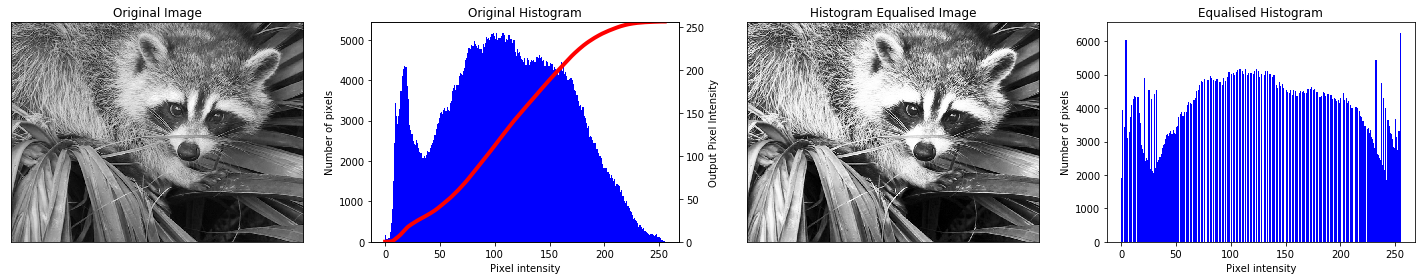

In [6]:
face_R = face[:, :, 0]

def histogram_equalisation():
    
    f = pl.figure(figsize = (20, 4))
    
    # Note: This is not the most efficient way to do this, but demontrates the principle
    hist, _ = np.histogram(face_R, bins = 256, normed=True)
    transfer_function = np.cumsum(hist)*255
    
    face_R_normed = face_R.copy()
    for i in range(face_R.shape[0]):
        for j in range(face_R.shape[1]):
            face_R_normed[i, j] = transfer_function[face_R[i, j]]
    
    ax1 = f.add_subplot(141)
    ax1.imshow(face_R, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Original Image")
    
    ax2 = f.add_subplot(142)
    ax2.hist(face_R.ravel(), bins = 255, color = 'b')
    ax2.set_xlabel('Pixel intensity'), ax2.set_ylabel('Number of pixels')
    ax2.set_title("Original Histogram")
    
    ax_xtra = ax2.twinx()
    ax_xtra.plot(transfer_function, 'r-', lw = 4.0)
    ax_xtra.set_ylabel("Output Pixel Intensity")
    ax_xtra.set_ylim((0, 255))
    
    ax3 = f.add_subplot(143)
    ax3.imshow(face_R_normed, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Histogram Equalised Image")
    
    ax4 = f.add_subplot(144)
    ax4.hist(face_R_normed.ravel(), bins = 255, color = 'b')
    ax4.set_xlabel('Pixel intensity'), ax4.set_ylabel('Number of pixels')
    ax4.set_title("Equalised Histogram")
    
    pl.tight_layout()
    pl.show()
    
histogram_equalisation()

## Adaptive Histogram Equalisation
<div style="float: left; width: 40%;">
<br>
<ul>
<li>Conventional histogram works well, but operates on the entire image.<br><br>
<li>More control can be gained by using a window of a specified width centered on each pixel, and transforming that pixel according to histogram equalisation within the given window.
</ul>
</div>
<div style="float: right; width: 50%;">
<img src='images/adaptive_histeq_example.jpg' width = '60%'>
</div>

In [7]:
from skimage.exposure import equalize_adapthist, equalize_hist

face_R = face[:, :, 0]

kernel_slider = FloatSlider(min=10, max=np.max(face_R.shape)/2, step=1, value=30, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_slider)
def histogram_adaptequalisation(kernel_size):
    
    f = pl.figure(figsize = (20, 4))
    
    face_R_normed = equalize_hist(face_R)*255
    face_R_normed_adaptive = equalize_adapthist(face_R, kernel_size = kernel_size)*255
    
    ax1 = f.add_subplot(141)
    ax1.imshow(face_R_normed, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Histogram Equalised")
    
    ax2 = f.add_subplot(142)
    ax2.hist(face_R_normed.ravel(), bins = 256, color = 'b')
    ax2.set_xlabel('Pixel intensity'), ax2.set_ylabel('Number of pixels')
    ax2.set_title("Equalised Histogram")
    
    ax3 = f.add_subplot(143)
    ax3.imshow(face_R_normed_adaptive, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Adaptive Histogram Equalised Image")
    
    ax4 = f.add_subplot(144)
    ax4.hist(face_R_normed_adaptive.ravel(), bins = 256, color = 'b')
    ax4.set_xlabel('Pixel intensity'), ax4.set_ylabel('Number of pixels')
    ax4.set_title("Adaptive Equalised Histogram")
    
    pl.tight_layout()
    pl.show()

interactive(children=(FloatSlider(value=30.0, continuous_update=False, description=u'kernel_size', max=512.0, min=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Spatial Operators
<div style="float: left; width: 55%;">
   <br>
   <ul>
    <li> Spatial operators modify the value of a pixel by taking into consideration the values of neighboring pixels.<br><br>
    <li> Typically the <b>neighborhood</b> is characterised as the "<i>N-neighborhood</i>", where "N" is the maximum distance between the pixel being considered and its neighbors in any dimension (chebyshev-distance).<br><br>
    <li> A <b>kernel</b> with values $a_{mn}$ within the neighborhood is then selected and convolved with the input image, $f_{ij}$ to produce the filtered image $g_{ij}$:<br><br>
        $$
          g(i, j) = \sum\limits_{m = -N}^{N}\sum\limits_{n = -N}^{N}a(m, n)\cdot f(i+m, j+n) = a\otimes f
        $$<br><br>
    <li> Care must be taken at the boudaries!  Two common approaches are to
        <ol>
            <li> Ignore pixels that are outside the image field-of-view
              <li> Pad the input images with 2N rows and columns
    </ol>
   </ul>
</div>
<div style="float: left; width: 45%;">
<img src="images/kernel_convolution.jpg" width="95%">
</div>

## Average Filter
 - A very straightforward filter is the average filter <br><br>
 - I takes the average pixels intensity within the kernel, acting as a __smoothing filter__ (sometimes called a "box filter" or "low-pass filter")<br><br>
 - It is important to ensure that $\sum\sum a(m, n) = 1$ , so that image intensity remains the same.<br><br>
 - The amount of smoothing can altered by changing the size of the kernel.

In [8]:
face_R_ds = face_R[0::3, 0::3]

kernel_size_slider = IntSlider(min=1, max=11, step=2, value=1, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_size_slider)
def average_filter_demo(kernel_size):
    
    f = pl.figure(figsize = (15, 4.4))
    
    ax1 = f.add_subplot(131)
    ax1.imshow(face_R_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Input Image, $f_{ij}$")
    
    ax2 = f.add_subplot(132)
    for i in np.linspace(-1, 1, kernel_size+1):
        pl.plot([i, i], [-1, 1], 'k-')
        pl.plot([-1, 1], [i, i], 'k-')
        if i < 1:
            for j in np.linspace(-1, 1, kernel_size+1):
                if j < 1:
                    pl.text(i + 1.0/kernel_size, j + 1.0/kernel_size, "$\\frac{1}{%d}$"%(kernel_size**2), 
                            horizontalalignment = 'center', verticalalignment = 'center', fontsize = 13)
    pl.axis('off')
    ax2.set_title("Kernel, $a_{mn}$")
    
    ax3 = f.add_subplot(133)
    
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    im_filtered = convolve2d(face_R_ds, kernel, mode='same',  boundary = "fill", fillvalue = 0)
    
    ax3.imshow(im_filtered, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Output Image, $g_{ij}$")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=11, min=1, step=2), Output()), _dom_classes=('widget-interact',))

## Weighted-Average Filter
 - Sometimes we don't want pixels on the edges of the kernel to have the same influence as the pixels closer to the center.<br><br>
 - We can use a different kernel value for each location, to ensure that all pixels are not considered equal during convolution ("weighting"). <br><br>
 - For example we could use:
 $$
 a(m, n) \propto \frac{1}{\beta + \sqrt{m^{2} + n^{2}}} \qquad \text{or}\qquad  a(m, n) \propto \frac{1}{2\pi\sigma}\exp\left\{ -\frac{m^{2} + n^{2}}{2\sigma^{2}} \right\}
 $$
 where $\beta$ and $\sigma$ are parameters we are free to choose (values only proportional as we need to ensure $\sum\sum a(m, n) = 1$)

In [9]:
face_R_ds = face_R[0::3, 0::3]

kernel_size_slider_2 = IntSlider(min=1, max=11, step=2, value=1, continuous_update=False)
d_slider = FloatSlider(min=0.01, max=1, step=0.01, value=1, continuous_update=False, description = r'\(\beta\)')

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_size_slider_2, d = d_slider)
def weighted_average_filter_demo(kernel_size, d):
    
    f = pl.figure(figsize = (15, 4.4))
    
    ax1 = f.add_subplot(131)
    ax1.imshow(face_R_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Input Image, $f(i, j)$")
    
    ax2 = f.add_subplot(132)
    for i in np.linspace(-1, 1, kernel_size+1):
        pl.plot([i, i], [-1, 1], 'k-')
        pl.plot([-1, 1], [i, i], 'k-')
        
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = 1.0 / (d + np.sqrt((i - kernel_size / 2)**2 + (j - kernel_size / 2)**2))
    kernel = kernel / kernel.sum ()
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            pl.text(-1 + (1.0 + 2 * i) / kernel_size, -1 + (1.0 + 2 * j) / kernel_size, "%.2f"%kernel[i, j], 
                        horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10)
    pl.axis('off')
    ax2.set_title("Kernel, $a(m, n)$")
    
    ax3 = f.add_subplot(133)
    
    im_filtered = convolve2d(face_R_ds, kernel, mode='same',  boundary = "fill", fillvalue = 0)
    
    ax3.imshow(im_filtered, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Output Image, $g(i, j)$")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=11, min=1, step=2), FloatSlider(value=1.0, continuous_update=False, description=u'\\(\\beta\\)', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

## Edge Detection Filters
 - Kernels are not only useful for removing the high frequency components in an image, they can be used to find the high frequency components (i.e. edges).<br><br>
 - One method to detect edges is to calculate the __gradient__ magnitude, $G$, of an image, $f$: $G = \sqrt{\left(\frac{\partial f}{\partial x}\right)^{2} + \left(\frac{\partial f}{\partial y}\right)^{2}}$<br><br>
 - The most basic approaches to calcaulte the gradient of a discrete function $G_{x}(i) \approx \frac{\partial f(i)}{\partial x}$ are the 'forward-difference' and 'center-difference' approaches:<br><br>
 $$
     \text{Forward-difference: } G_{x}(i) = f(i+1) - f(i)\qquad \text{Center-difference: } G_{x}(i) = \frac{f(i+1) - f(i-1)}{2}
 $$

In [10]:
def plot_filter(filter, ax, fontsize = 15):
    if not filter.shape == (3, 3):
        raise Exception("Filter must me a 3x3 ndarray")
    
    for i in range(4):
        ax.plot([i, i], [0, 3], 'k-')
        ax.plot([0, 3], [i, i], 'k-')
    
    for i in range(3):
        for j in range(3):
            ax.text(i+0.5, j+0.5, "%s"%str(filter[j, i]), fontsize=fontsize, horizontalalignment = 'center', verticalalignment = 'center')
    
    ax.set_xlim((-0.1, 3.1)), ax.set_ylim((-0.1, 3.1))
    ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False), ax.spines['bottom'].set_visible(False)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_aspect('equal')

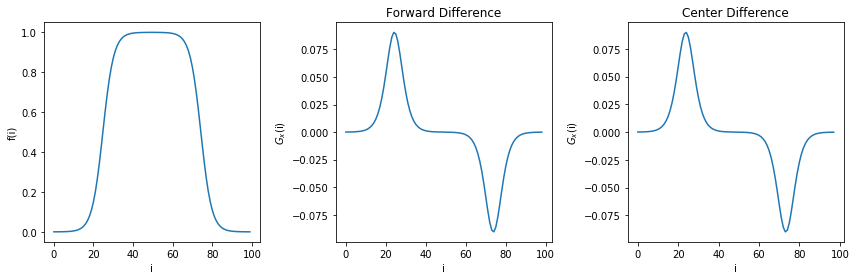

In [11]:
def example_func(x):
    return 1.0 / (1 + np.exp(-3 * (-np.abs(x) + 3)))

def plot_forward_center_difference():

    x = np.linspace(-6, 6, 100)
    f = example_func(x)
    f_fd = f[1::] - f[0:-1]
    f_cd = (f[2::] - f[0:-2]) / 2
    
    fig = pl.figure(figsize = (12, 4))
    
    ax1 = fig.add_subplot(131)
    ax1.plot(f)
    ax1.set_xlabel('i'), ax1.set_ylabel('f(i)')
    
    ax2 = fig.add_subplot(132)
    ax2.plot(f_fd)
    ax2.set_xlabel('i'), ax2.set_ylabel('$G_{x}$(i)')
    ax2.set_title('Forward Difference')
    
    ax3 = fig.add_subplot(133)
    ax3.plot(f_cd)
    ax3.set_xlabel('i'), ax3.set_ylabel('$G_{x}$(i)')
    ax3.set_title('Center Difference')
    
    pl.tight_layout()
    pl.show()
    
plot_forward_center_difference()

## Edge Detection Filters

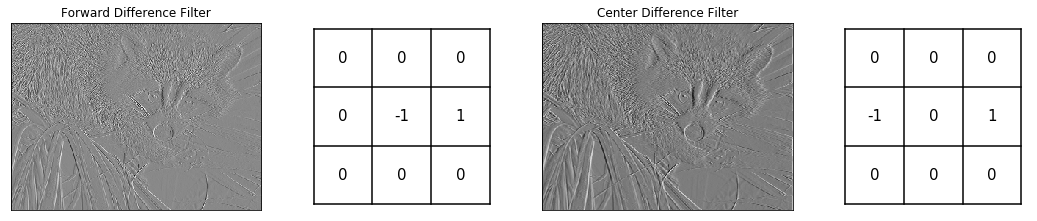

In [12]:
def show_forward_ceter_examples():
    
    fd_filter = np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]])
    cd_filter = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
    
    face_ds = face_R[0::3, 0::3]
    face_fd = convolve2d(face_ds, fd_filter, mode = 'same')
    face_cd = convolve2d(face_ds, cd_filter, mode = 'same')
    
    fig = pl.figure(figsize = (15, 3))
    
    ax1 = fig.add_subplot(141)
    ax1.imshow(face_fd, cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Forward Difference Filter")
    
    ax2 = fig.add_subplot(142)
    plot_filter(fd_filter, ax2)
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(face_cd, cmap = 'gray', interpolation = 'None')
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Center Difference Filter")

    ax4 = fig.add_subplot(144)
    plot_filter(cd_filter, ax4)
    
    pl.tight_layout()
    pl.show()
    
show_forward_ceter_examples()
    

These methods are a little noisy, but we can improve this by averaging over the orthogonal direction:

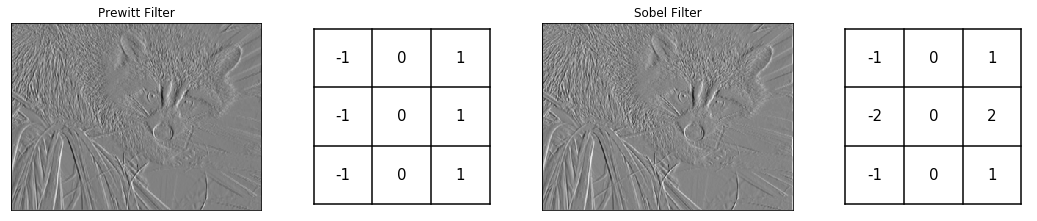

In [13]:
def show_forward_ceter_examples():
    
    prewitt_filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    
    face_ds = face_R[0::3, 0::3]
    face_prewitt = convolve2d(face_ds, prewitt_filter, mode = 'same')
    face_sobel = convolve2d(face_ds, sobel_filter, mode = 'same')
    
    fig = pl.figure(figsize = (15, 3))
    
    ax1 = fig.add_subplot(141)
    ax1.imshow(face_prewitt, cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Prewitt Filter")
    
    ax2 = fig.add_subplot(142)
    plot_filter(prewitt_filter, ax2)
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(face_sobel, cmap = 'gray', interpolation = 'None')
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Sobel Filter")

    ax4 = fig.add_subplot(144)
    plot_filter(sobel_filter, ax4)
    
    pl.tight_layout()
    pl.show()
    
show_forward_ceter_examples()
    

## Edge Detection Filters

We can apply these filters in either direction (assuming we use the sobel definition from now on!).

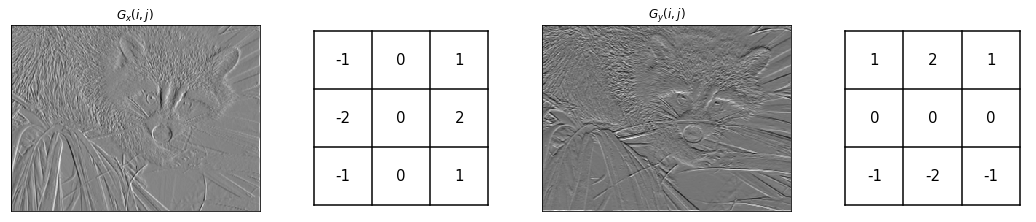

In [14]:
def show_sobel_examples():
    
    sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    face_ds = face_R[0::3, 0::3]
    face_sobel_x = convolve2d(face_ds, sobel_filter_x, mode = 'same')
    face_sobel_y = convolve2d(face_ds, sobel_filter_y, mode = 'same')
    
    fig = pl.figure(figsize = (15, 3))
    
    ax1 = fig.add_subplot(141)
    ax1.imshow(face_sobel_x, cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("$G_{x}(i, j)$")
    
    ax2 = fig.add_subplot(142)
    plot_filter(sobel_filter_x, ax2)
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(face_sobel_y, cmap = 'gray', interpolation = 'None')
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("$G_{y}(i, j)$")

    ax4 = fig.add_subplot(144)
    plot_filter(sobel_filter_y, ax4)
    
    pl.tight_layout()
    pl.show()
    
show_sobel_examples()
    

These can be converted into the __magnitude__:
$$
  G(i, j) = \sqrt{G_{x}^{2} + G_{y}^{2}}
$$

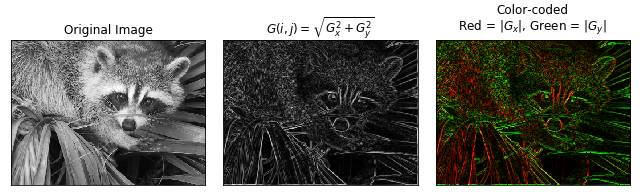

In [15]:
def show_magnitude_phase():
    
    sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    face_ds = face_R[0::3, 0::3]
    face_sobel_x = convolve2d(face_ds, sobel_filter_x, mode = 'same')
    face_sobel_y = convolve2d(face_ds, sobel_filter_y, mode = 'same')
    
    gradient = np.sqrt(face_sobel_x**2 + face_sobel_y**2)
    
    fig = pl.figure(figsize = (9, 3))
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(face_R_ds, cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Original Image")
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(gradient, cmap = 'gray', interpolation = 'None')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("$G(i, j) = \sqrt{G_{x}^{2} + G_{y}^{2}}$")
    
    R = np.abs(face_sobel_x)
    G = np.abs(face_sobel_y)
    B = np.zeros(face_R_ds.shape)
    RGB = np.stack([R, G, B]).transpose((1, 2, 0))
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(RGB.astype('float')/(RGB.max() / 1.5))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Color-coded\nRed = |$G_{x}$|, Green = |$G_{y}$|")

    pl.tight_layout()
    pl.show()
    
show_magnitude_phase()
    

## Laplacian Filter
 - Similarly to the the gradient magnitude, we can define the laplacian of an image as: <br><br>
 $$
 \nabla^{2}f = \frac{\partial^{2}f}{\partial x^{2}} + \frac{\partial^{2}f}{\partial y^{2}}
 $$<br><br>
 - The laplacian has the advantage that it is __rotationally invariant__.<br><br>
 - As for the gradient operator, we can define the __laplacian kernel__, $L$, for digital images such that
 $$
     \nabla^{2}f \approx L \otimes f
 $$

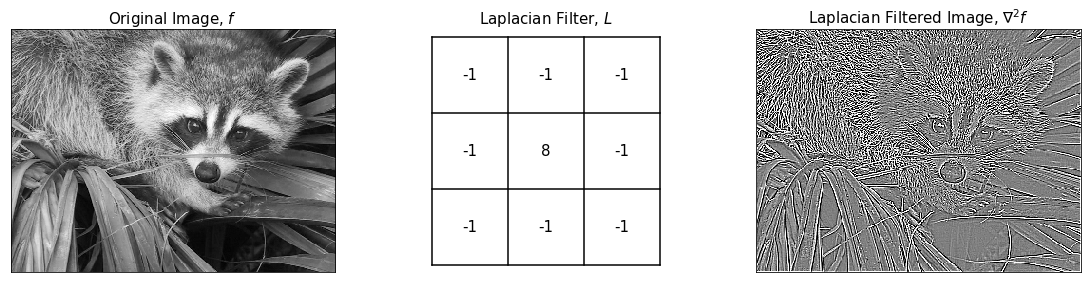

In [16]:
def show_laplacian():
    
    laplacian_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    
    face_ds = face_R[0::3, 0::3]
    face_laplacian = convolve2d(face_ds, laplacian_filter, mode = 'same')
    
    fig = pl.figure(figsize = (16, 4))
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(face_R_ds, cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Original Image, $f$", fontsize = 15)
    
    ax2 = fig.add_subplot(132)
    plot_filter(laplacian_filter, ax2)
    ax2.set_title("Laplacian Filter, $L$", fontsize = 15)
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(face_laplacian, cmap = 'gray', clim = (-200, 200))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Laplacian Filtered Image, $\\nabla^{2}f$", fontsize = 15)

    pl.tight_layout()
    pl.show()
    
show_laplacian()

## Unsharp Masking
<div style="float: left; width: 65%;">
 <br>
 <ul>
     <li>We can also use the laplacian filter to highlight areas in the image with high-frequency components. <br><br>
    <li>This is sometimes called <b>image sharpening</b><br><br>
     <li>We generate a new image using the operation
     \begin{align}
         g &= f + \lambda \nabla^{2}f \\
         &\approx f + \lambda L\otimes f\\
         & = (1 + \lambda L)\otimes f
     \end{align}
 </ul>
 </div>
 <div style="float: left; width: 35%;">
 <img src='images/unsharp_kernel.jpg' width = '80%'>
 </div>

In [17]:

lambda_slider = FloatSlider(min=0, max=0.5, step=0.001, value=0, continuous_update=False, description = r'\(\lambda\)')

# decorate the plot function with an environment from the UIs:
@interact(l = lambda_slider)
def average_filter_demo(l):
    
    f = pl.figure(figsize = (5, 5))
    
    face_ds = face_R[0::4, 0::4]
    kernel = np.array([[-l, -l, -l], [-l, 1+8*l, -l], [-l, -l, -l]])
    filtered = convolve2d(face_ds, kernel, mode = 'same')
    
    ax1 = f.add_subplot(111)
    ax1.imshow(filtered, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'\\(\\lambda\\)', max=0.5, step=0.001), Output()), _dom_classes=('widget-interact',))

## Median Filter
 - Kernels don't necessarily have to be convolved with the image!<br><br>
 - We can use kernels to act as a window that we slide over every position in the image and perform some operation (other than a weighted summation)<br><br>
 - For example, if we take the __meidan__ of the image values within the kernel, we end up with the __median filter__<br><br>
 - Again the effect of the filter increases with an incresing kernel size:

In [18]:
from skimage.filters import median

m_kernel_size_slider = IntSlider(min=1, max=11, step=2, value=1, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = m_kernel_size_slider)
def meidan_filter_demo(kernel_size):
    
    face_ds = face_R[0::3, 0::3]
    
    f = pl.figure(figsize = (15, 4.4))
    
    ax1 = f.add_subplot(131)
    ax1.imshow(face_R_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Input Image$")
    
    ax2 = f.add_subplot(132)
    for i in np.linspace(-1, 1, kernel_size+1):
        pl.plot([i, i], [-1, 1], 'k-')
        pl.plot([-1, 1], [i, i], 'k-')
    ax2.set_aspect('equal')
    pl.axis('off')
    ax2.set_title("Kernel")
    
    ax3 = f.add_subplot(133)
    im_filtered = median(face_ds, selem=np.ones((kernel_size, kernel_size)))
    
    ax3.imshow(im_filtered, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Median Filtered Image")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=11, min=1, step=2), Output()), _dom_classes=('widget-interact',))

## Transform Operators
 - Rather than working directly on image space, we can work with some other transformation space<br><br>
 - The most common methods work in the frequency (Fourier) space of the image, and then an inverse Fourier Transform is used to recover the filtered image.<br><br>
 - An example of this is the __low pass__ filters:

In [19]:
FWHM_slider = FloatSlider(min=1, max=400, step=1, value=400, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(FWHM = FWHM_slider)
def lowpass_filter_demo(FWHM):
    
    face_ds = face_R[0::3, 0::3]
    faceFFT = fft.fftshift(fft.fft2(face_ds))
    
    x = np.linspace(-face_ds.shape[1]/2, face_ds.shape[1]/2, face_ds.shape[1])
    y = np.linspace(-face_ds.shape[0]/2, face_ds.shape[0]/2, face_ds.shape[0])
    X, Y = np.meshgrid(x, y)
    
    var = (FWHM / 2.355)**2
    
    gaussian_mask = np.exp( - 0.5 * (X**2 + Y**2) / var)
    circular_mask = 1.0*(gaussian_mask > 0.5)
    
    circular_filtered_FFT = circular_mask * faceFFT
    circular_filtered_image = fft.ifft2(fft.fftshift(circular_filtered_FFT))
    gaussian_filtered_FFT = gaussian_mask * faceFFT
    gaussian_filtered_image = fft.ifft2(fft.fftshift(gaussian_filtered_FFT))
    
    f = pl.figure(figsize = (15, 4.4))
    
    ax1 = f.add_subplot(141)
    FFT_display = np.log(np.abs(circular_filtered_FFT))
    FFT_display[~np.isfinite(FFT_display)] = 0
    ax1.imshow(FFT_display, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Circular Filtered FT")
    
    ax2 = f.add_subplot(142)
    ax2.imshow(np.abs(circular_filtered_image), cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Circular Filtered Image")
    
    ax1 = f.add_subplot(143)
    FFT_display = np.log(np.abs(gaussian_filtered_FFT))
    FFT_display[~np.isfinite(FFT_display)] = FFT_display[np.isfinite(FFT_display)].min()
    ax1.imshow(FFT_display, cmap = 'gray', clim = (0, 16))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Gaussian Filtered FT")
    
    ax2 = f.add_subplot(144)
    ax2.imshow(np.abs(gaussian_filtered_image), cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Gaussian Filtered Image")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(FloatSlider(value=400.0, continuous_update=False, description=u'FWHM', max=400.0, min=1.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Transform Operators

 - An alternative is to use a __high pass__ filter that only selectes the high frequency components:

In [20]:
from skimage.filters import median

high_FWHM_slider = FloatSlider(min=1, max=50, step=0.01, value=1, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(FWHM = high_FWHM_slider)
def highpass_filter_demo(FWHM):
    
    face_ds = face_R[0::3, 0::3]
    faceFFT = fft.fftshift(fft.fft2(face_ds))
    
    x = np.linspace(-face_ds.shape[1]/2, face_ds.shape[1]/2, face_ds.shape[1])
    y = np.linspace(-face_ds.shape[0]/2, face_ds.shape[0]/2, face_ds.shape[0])
    X, Y = np.meshgrid(x, y)
    
    var = (FWHM / 2.355)**2
    
    gaussian_mask = 1.0 - np.exp( - 0.5 * (X**2 + Y**2) / var)
    circular_mask = 1.0*(gaussian_mask > 0.5)
    
    circular_filtered_FFT = circular_mask * faceFFT
    circular_filtered_image = fft.ifft2(fft.fftshift(circular_filtered_FFT))
    gaussian_filtered_FFT = gaussian_mask * faceFFT
    gaussian_filtered_image = fft.ifft2(fft.fftshift(gaussian_filtered_FFT))
    
    f = pl.figure(figsize = (15, 3.5))
    
    ax1 = f.add_subplot(141)
    FFT_display = np.log(np.abs(circular_filtered_FFT))
    FFT_display[~np.isfinite(FFT_display)] = 0
    ax1.imshow(FFT_display, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Circular Filtered FT")
    
    ax2 = f.add_subplot(142)
    ax2.imshow(np.abs(circular_filtered_image), cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Circular Filtered Image")
    
    ax1 = f.add_subplot(143)
    FFT_display = np.log(np.abs(gaussian_filtered_FFT))
    FFT_display[~np.isfinite(FFT_display)] = FFT_display[np.isfinite(FFT_display)].min()
    ax1.imshow(FFT_display, cmap = 'gray', clim = (0, 16))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Gaussian Filtered FT")
    
    ax2 = f.add_subplot(144)
    ax2.imshow(np.abs(gaussian_filtered_image), cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Gaussian Filtered Image")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'FWHM', max=50.0, min=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

 - Or we may choose a __band pass__ filter:

In [21]:
from skimage.filters import median

FWHM_slider_1 = FloatSlider(min=1, max=50, step=0.01, value=1, continuous_update=False)
FWHM_slider_2 = FloatSlider(min=50, max=400, step=1, value=400, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(FWHM1 = FWHM_slider_1, FWHM2 = FWHM_slider_2)
def highpass_filter_demo(FWHM1, FWHM2):
    
    face_ds = face_R[0::3, 0::3]
    faceFFT = fft.fftshift(fft.fft2(face_ds))
    
    x = np.linspace(-face_ds.shape[1]/2, face_ds.shape[1]/2, face_ds.shape[1])
    y = np.linspace(-face_ds.shape[0]/2, face_ds.shape[0]/2, face_ds.shape[0])
    X, Y = np.meshgrid(x, y)
    
    var1 = (FWHM1 / 2.355)**2
    var2 = (FWHM2 / 2.355)**2
    
    gaussian_mask = (1.0 - np.exp(-0.5 * (X**2 + Y**2) / var1)) * np.exp(-0.5 * (X**2 + Y**2) / var2)
    gaussian_mask = gaussian_mask / gaussian_mask.max()
    circular_mask = 1.0*(gaussian_mask > 0.5)
    
    circular_filtered_FFT = circular_mask * faceFFT
    circular_filtered_image = fft.ifft2(fft.fftshift(circular_filtered_FFT))
    gaussian_filtered_FFT = gaussian_mask * faceFFT
    gaussian_filtered_image = fft.ifft2(fft.fftshift(gaussian_filtered_FFT))
    
    f = pl.figure(figsize = (7.5, 3.0))
    
    ax1 = f.add_subplot(121)
    FFT_display = np.log(np.abs(circular_filtered_FFT))
    FFT_display[~np.isfinite(FFT_display)] = 0
    ax1.imshow(FFT_display, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Band-Pass Filtered FT")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(np.abs(circular_filtered_image), cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Band-Pass Filtered Image")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'FWHM1', max=50.0, min=1.0, step=0.01), FloatSlider(value=400.0, continuous_update=False, description=u'FWHM2', max=400.0, min=50.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Transform Operators
 - Ultimately, these filters take the form:<br><br>
\begin{align}
     g &= \text{FT}^{-1}\{G\} \\ 
       &= \text{FT}^{-1}\{A\cdot F\},\quad\quad\quad\quad\ \text{(A is the filter and F is the FT of the iinput image)} \\
       &= \text{FT}^{-1}\{A\} \circledast \text{FT}^{-1}\{F\}, \quad \text{(convlution theorem)}\\
       &= a \circledast f
\end{align}<br><br>
 - This shows that, at least in principle, transfrom operators are _equvalent_ to convolution of the image, $f$, with some appropriate kernel, $a$, as we explored in the preceeding section. <br><br>
 - Many transform operators can serve a surrogates for spatial operators and vice versa!

## Image Noise
<div style="float: left; width: 50%;">
<br>
<ul>
 <li>No image is perfect!<br><br>
 <li>Images cannot perfectly replicate the object, they just capture enough information to provide a reasonable representation of it.<br><br>
 <li>We have already seen how the point-spread function (PSF) of an imaging system captures the information required to describe the <i>geometric</i> inaccuracies of the image.<br><br>
    <li>However, another major factor that degardes image quality is <b>noise</b>.<br><br>
 <li> All images are affected by noise so some degree, and the type of noise will depend on the imaging system being used.
 </ul>
 </div>
 <div style="float: right; width: 40%;">
<img src="images/noise_examples.jpg" width="90%">
</div>

## Image Noise
<div style="float: left; width: 50%;">
<br>
<ul>
 <li>So how do we characterise imaging noise?<br><br>
 <li>The histogram of pixel intensity values within a homogeoneous looking are within the liver on CT demonstrates there is spread in the values.<br><br>
 <li>By calculating the mean, $\mu$, and standard deviation, $\sigma$, of the pixel values we obtain a fit of the data to a <b>Gaussian Distribution</b>:<br><br>
     $$
         \# \propto \frac{1}{\sigma\sqrt{2\pi}}\exp\left( -\frac{(HU - \mu)^{2}}{2\sigma^{2}} \right)\qquad\left( = \mathcal{N}(HU, \sigma) \right)
     $$<br><br>
 <li>This represents a key property hypothesis that is assumed in most imaging applications: Noise can be characterised by a <b>probability distribution</b>.
<ul>
</div>
<div style="float: right; width: 40%;">
<img src="images/CT_roi.tif" width="70%">
<img src="images/CT_histogram.pdf" width="90%">
</div>

## Gaussian Noise
<div style="float: left; width: 100%;">
<br>
<ul>
 <li>Gaussian noise is a good assumption in many imaging applications.<br><br>
 <li>In many systems it can result from thermal fluctuations in the current within electrical circuits that add to the final image signal ('Johnson noise').<br><br>
    <li>Gaussian noise is <b>additive</b> to a noise-free image, $f$:<br><br>
\begin{align}
     g(i, j) = f(i, j) + \varepsilon(i, j)
\end{align}<br><br>
where $\varepsilon \sim \mathcal{N}(0, \sigma)$ is random noise sampled from a Gaussian ditribution.
</ul>
</div>

In [22]:
std_slider = FloatSlider(min=1, max=75, step=1, value=1, continuous_update=False, description = r'\(\sigma\)')

# decorate the plot function with an environment from the UIs:
@interact(std = std_slider)
def gaussian_example(std):
    
    face_ds = face_R[0::3, 0::3]
    noise = np.random.randn(*face_ds.shape)*std
    face_noisy = face_ds + noise
    x = np.linspace(-150, 150, 100)
    p = 1.0/np.sqrt(2*np.pi*std**2) * np.exp(-0.5 * x**2 / std**2)
    
    f = pl.figure(figsize = (16, 3.5))
    
    ax1 = f.add_subplot(141)
    ax1.imshow(face_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("$f(i, j)$")
    
    ax2 = f.add_subplot(142)
    ax2.imshow(noise, cmap = 'gray', clim = (-255, 255))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("$\epsilon(i, j)$")
    
    ax3 = f.add_subplot(143)
    ax3.imshow(face_noisy, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("$g(i, j) = f(i, j) + \epsilon(i, j)$")
    
    ax4 = f.add_subplot(144)
    ax4.plot(x, p, 'k-', lw = 2)
    ax4.set_ylim((0, 0.10))
    ax4.set_xlabel("$\epsilon$", fontsize = 13), ax4.set_ylabel("$p(\epsilon)$", fontsize = 13)
    ax4.text(150, 0.09, "$\sigma$ = %d"%std, verticalalignment = "top", horizontalalignment = "right")
    ax4.set_title("$p(\epsilon) = \mathcal{N}(0, \sigma)$")
    
    pl.tight_layout()
    pl.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'\\(\\sigma\\)', max=75.0, min=1.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Guassian Noise
- We can use one of our earlier filters to try and help remove the noise!

In [23]:
from skimage import io
CT_im = io.imread('images/CT_full.tif')[:, :, 0]

kernel_size_slider_CT = IntSlider(min=1, max=15, step=2, value=1, continuous_update=False)
d_slider_CT = FloatSlider(min=0.01, max=0.4, step=0.01, value=1, continuous_update=False, description = r'\(\beta\)')

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_size_slider_CT, d = d_slider_CT)
def weighted_average_CT_demo(kernel_size, d):
    
    f = pl.figure(figsize = (16, 7))
    
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = 1.0 / (d + np.sqrt((i - kernel_size / 2)**2 + (j - kernel_size / 2)**2))
    
    CT_ds = CT_im[0::4, 0::4]
    kernel = kernel / kernel.sum ()
    CT_filtered = convolve2d(CT_ds, kernel, mode='same',  boundary = "fill", fillvalue = 0)
    
    ax1 = f.add_subplot(121)
    ax1.imshow(CT_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Original Image")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(CT_filtered, cmap = 'gray', clim = (0, 255))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Filtered Image")
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=15, min=1, step=2), FloatSlider(value=0.4, continuous_update=False, description=u'\\(\\beta\\)', max=0.4, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

## Poisson Noise
 - Also refered to as __shot noise__, describes the noise associated with counting processes (e.g. photon counting in CCD cameras, PET imaging)<br><br>
 - Can no longer assume that noise is additive, as the amount of noise added to each pixel location depends on the pixel value itself.<br><br>
 - The probability of detecting $g$ counts, given that the true number should be $f$ is:<br><br>
 $$
 p(g|f) = e^{-f}\cdot\frac{f^{g}}{g!}
 $$

In [24]:
from scipy.special import loggamma
from scipy.stats import poisson

im_max_slider = FloatSlider(min=4, max=100, step=1, value=255, continuous_update=False, description = r'$f$ Maximum')

# decorate the plot function with an environment from the UIs:
@interact(im_max = im_max_slider, d = d_slider_CT)
def show_poisson(im_max):
    
    face_ds = (face_R[0::3, 0::3] * im_max / 255).astype('int')
    face_noise = np.random.poisson(face_ds)
    noise = face_noise - face_ds
    
    fig = pl.figure(figsize = (17, 3.5))
    
    ax1 = fig.add_subplot(141)
    ax1.imshow(face_ds, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("True Counts, $f$")
    
    ax2 = fig.add_subplot(142)
    ax2.imshow(face_noise, cmap = 'gray')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Measured Counts, $g$")
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(noise, cmap = 'gray')
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Noise Field ($g - f$)")
    
    g = np.arange(1, int(2*im_max))
    ax4 = fig.add_subplot(144)
    p_max = 0
    for g_ in g:
        p = poisson.pmf(g_, mu = im_max)
        ax4.plot([g_, g_], [0, p], "b-")
        ax4.plot([g_], [p], "bo")
        if p > p_max:
            p_max = p
            
    ax4.set_xlim(1, g.max()), ax4.set_ylim((0, 1.1*p_max))
    ax4.set_title("$p(g|f) = e^{-%d}\cdot %d^{g} / g!$"%(im_max, im_max))
    ax4.set_xlabel("$g$")
    ax4.set_ylabel("$p(g|f)$")
    
    pl.tight_layout()
    pl.show()

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description=u'$f$ Maximum', min=4.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Salt and Pepper Noise
 - This type of noise typically characterises individual pixels that are faulty within a sensor, ot have perhaps been saturated by some radiation source (e.g. high energy x-rays detected by a light sensor).<br><br>
 - Additive noise can be modelled using zero-centered 'heavy-tail' probability distributions (have an undefined mean, standard deviation etc.)<br><br>
 - As an example, we can use the Cauchy distribution, which has the form:<br><br>
 $$
 p(\varepsilon|\gamma) = \frac{1}{\pi\gamma\left(1+\left[\frac{\varepsilon}{\gamma}\right]^{2}\right)}
 $$ 

In [25]:
gamma_slider = FloatSlider(min=0.01, max=100, step=0.01, value=1, continuous_update=False, description = r'\(\gamma\)')

# decorate the plot function with an environment from the UIs:
@interact(gamma = gamma_slider)
def salt_pepper_example(gamma):
    
    face_ds = face_R[0::3, 0::3]
    noise = np.random.standard_cauchy(face_ds.shape) * gamma
    face_noise = face_ds + noise
    
    fig = pl.figure(figsize = (17, 3.5))
    
    ax1 = fig.add_subplot(141)
    ax1.imshow(face_ds, cmap = 'gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("True Image, $f$")
    
    ax2 = fig.add_subplot(142)
    ax2.imshow(face_noise, cmap = 'gray', clim = (0, 255))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Noisy Image, $g$")
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(noise, cmap = 'gray', clim = (0, 255))
    ax3.set_xticks([]), ax3.set_yticks([])
    ax3.set_title("Noise Field ($g - f$)")
    
    ax4 = fig.add_subplot(144)
    e = np.linspace(-255, 255, 1000)
    p = 1.0 / (gamma * np.pi * (1 + (e/gamma)**2))
    ax4.plot(e, p, 'k-')
    ax4.set_xlabel("$\epsilon$")
    ax4.set_ylabel("$p(\epsilon)$")
    
    pl.tight_layout()
    pl.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'\\(\\gamma\\)', min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

## Salt and Pepper Noise
 - So can we smooth out this noise?<br><br>
 - Smoothing with a weighted-kernel (from earlier):<br><br>

In [26]:
from skimage import io
CT_im = io.imread('images/CT_full.tif')[:, :, 0]

kernel_size_slider_CT_sp = IntSlider(min=1, max=15, step=2, value=1, continuous_update=False)
d_slider_CT_sp = FloatSlider(min=0.01, max=0.4, step=0.01, value=1, continuous_update=False, description = r'\(\beta\)')

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_size_slider_CT_sp, d = d_slider_CT_sp)
def weighted_average_CT_sp_demo(kernel_size, d):
    
    f = pl.figure(figsize = (16, 7))
    
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = 1.0 / (d + np.sqrt((i - kernel_size / 2)**2 + (j - kernel_size / 2)**2))
    
    CT_ds = CT_im[0::4, 0::4] 
    CT_ds = CT_ds * 255.0 / CT_ds.max()
    noise = np.random.standard_cauchy(CT_ds.shape) * 3
    CT_ds = CT_ds + noise
    
    kernel = kernel / kernel.sum ()
    CT_filtered = convolve2d(CT_ds, kernel, mode='same',  boundary = "fill", fillvalue = 0)
    
    ax1 = f.add_subplot(121)
    ax1.imshow(CT_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Noisy Image")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(CT_filtered, cmap = 'gray', clim = (0, 255))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Filtered Image")
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=15, min=1, step=2), FloatSlider(value=0.4, continuous_update=False, description=u'\\(\\beta\\)', max=0.4, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

## Salt and Pepper Noise
- Normal smoothing filters don't work as heavy-tail distributions don't have a mean!<br><br>
- There is one more filter we can try:<br><br>

In [47]:
from skimage import io
from skimage.filters import median
CT_im = io.imread('images/CT_full.tif')[:, :, 0]

kernel_size_slider_CT_median = IntSlider(min=1, max=15, step=2, value=1, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(kernel_size = kernel_size_slider_CT_median)
def weighted_average_CT_median_demo(kernel_size):
    
    f = pl.figure(figsize = (16, 7))
    
    CT_ds = CT_im[0::4, 0::4] 
    CT_ds = CT_ds * 255.0 / CT_ds.max()
    noise = np.random.standard_cauchy(CT_ds.shape) * 3
    CT_ds = np.clip(CT_ds + noise, 0, 255).astype('int')
    
    CT_filtered = median(CT_ds.astype('int'), selem = np.ones((kernel_size, kernel_size)))
    
    ax1 = f.add_subplot(121)
    ax1.imshow(CT_ds, cmap = 'gray', clim = (0, 255))
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Noisy Image")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(CT_filtered, cmap = 'gray', clim = (0, 255))
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Median Filtered Image")
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'kernel_size', max=15, min=1, step=2), Output()), _dom_classes=('widget-interact',))

## Practical Noise Considerations
<div style="float: left; width: 50%;">
<br>
<ul>
<li>In most imaging systems it is impractical / impossible to accurately identify the noise distribution.<br><br>
<li>In reality noise will occur from a variety of sources with different distributions; for example in ultrasound we have electrical Gaussian noise within the detector elements <b>and</b> speckle originating within the patient. <br><br>
    <li>In many applications it is sufficient to assume the noise is <b>Gaussian</b> and <b>additive</b>.<br><br>
<li>We can look at the distribution of noise by drawing a region within 'uniform' part of the image, and measure the <b>standard deviation</b> of the contained pixel values as a measure of the spread of the noise distribution.<br><br>
<li> Uniform test-objects (phantoms) can also be used to ensure that we do not measure biological variation.
</div>
<div style="float: right; width: 40%;">
<img src="images/CT_roi.tif" width="70%">
<img src="images/CT_histogram.pdf" width="90%">
</div>

## Practical Noise Considerations
 - There are a number of useful indices we can quote to give some idea about the noise perfomance of our imaging system.<br><br>
 - The __signal-to-noise ratio__ (SNR) identifies the relative amplitude of the signal we are trying to measure, $S$, to the magnitude of noise in the image:
 $$
 \text{SNR} = \frac{S}{\sigma_{\varepsilon}}
 $$
 - The __contrast-to-noise ratio__ (CNR) on the other hand measures the ability of an imaging system to discriminate between two objects (with signals $S_{1}$ and $S_{2}$) in the presence of noise:
 $$
 \text{CNR} = \frac{|S_{2} - S_{1}|}{\sigma_{\varepsilon}}
 $$
 

In [48]:
contrast_slider_CNR = FloatSlider(min=0, max=1, step=0.01, value=0, continuous_update=False)
SNR_slider_CNR = FloatSlider(min=0.5, max=10, step=0.01, value=5, continuous_update=False, description = "SNR")

# decorate the plot function with an environment from the UIs:
@interact(snr = SNR_slider_CNR, contrast = contrast_slider_CNR)
def contrast_example_CNR(snr, contrast):
    
    S_1 = (1.0 + contrast) / 2 * np.ones((100, 50))
    S_2 = (1.0 - contrast) / 2 * np.ones((100, 50))
    S = np.hstack([S_1, S_2])
    
    sigma = (1.0 + contrast) / (2 * snr)
    CNR = np.abs(contrast) / sigma
    SNR_2 = ((1.0 - contrast) / 2) / sigma
    
    noise = np.random.randn(*S.shape) * sigma
    S = S + noise
    
    f = pl.figure(figsize = (5, 5))
    
    ax1 = f.add_subplot(111)
    ax1.imshow(S, cmap = 'gray', origin = 'lower', clim = (-2, 2))
    ax1.set_xticks([]), ax1.set_yticks([])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax1.text(95, 95, "SNR = %.2f\nCNR = %.2f"%(SNR_2, CNR), verticalalignment = 'top', horizontalalignment = 'right', bbox = props)
    ax1.text(5, 95, "SNR = %.2f"%snr, verticalalignment = 'top', horizontalalignment = 'left', bbox = props)
    
    pl.show()

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description=u'SNR', max=10.0, min=0.5, step=0.01), FloatSlider(value=0.0, continuous_update=False, description=u'contrast', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

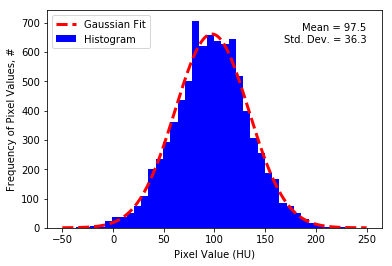

In [29]:
vals = np.loadtxt('/Users/adminmblackledge/Desktop/test.txt')
m = np.mean(vals)
s = np.std(vals, ddof = 1)
x = np.linspace(-50, 250, 1000)
p = 1.0/np.sqrt(2*np.pi*s**2)*np.exp(-0.5*(x-m)**2 / s**2)
f = pl.figure()
ax = f.add_subplot(111)
bins, hvals, _ = ax.hist(vals, bins = 40, color = 'b', label = "Histogram")
ax.plot(x, p*len(vals)*(hvals[1] - hvals[0]), 'r--', lw = 3.0, label = "Gaussian Fit")
ax.text(250, 700, "Mean = %.1f\nStd. Dev. = %.1f"%(m, s), verticalalignment = 'top', horizontalalignment = 'right')
ax.set_xlabel("Pixel Value (HU)")
ax.set_ylabel("Frequency of Pixel Values, #")
pl.legend(loc = 2)
pl.savefig("images/CT_histogram.pdf")
pl.show()